In [1]:
import pandas as pd
from pandas.plotting import register_matplotlib_converters
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline


register_matplotlib_converters()

plt.style.use('ggplot')

# 2020 Coronavirus Australia

Data taken from https://en.wikipedia.org/wiki/2020_coronavirus_outbreak_in_Australia

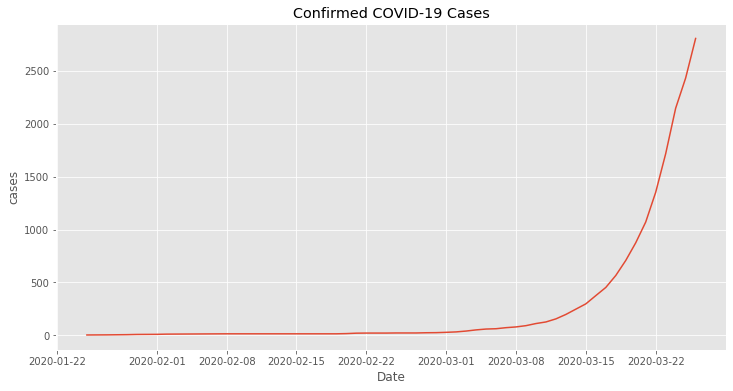

In [13]:
df = pd.read_csv('au_total.csv')
df = df.iloc[:-1]

df.date = pd.to_datetime(df.date, format="%d/%m/%Y")

fig = plt.figure(figsize=(12, 6))


plt.plot(df.date, df.confirmed)
plt.title('Confirmed COVID-19 Cases');
plt.xlabel('Date');
plt.ylabel('cases');

# Semi - Log Plot of Cases

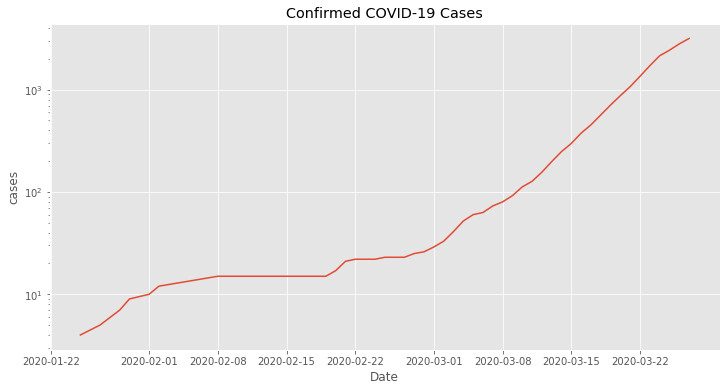

In [6]:
fig = plt.figure(figsize=(12, 6))
plt.plot(df.date, df.confirmed)
plt.title('Confirmed COVID-19 Cases');
plt.xlabel('Date');
plt.ylabel('cases');
plt.yscale('log')

# Deaths

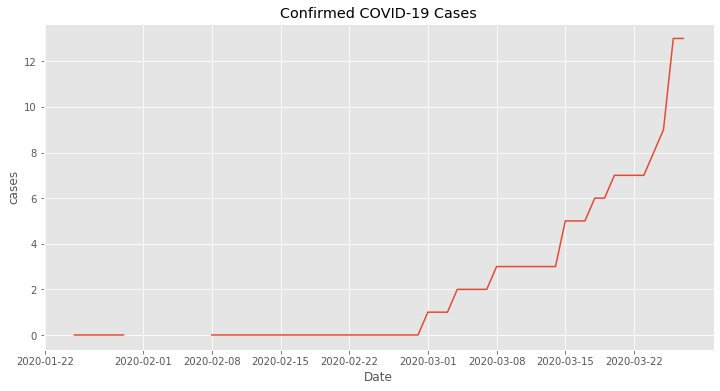

In [8]:
fig = plt.figure(figsize=(12, 6))
plt.plot(df.date, df.deaths)
plt.title('Confirmed COVID-19 Cases');
plt.xlabel('Date');
plt.ylabel('cases');
#plt.yscale('log')

# Exponential Curve Fit

a: 0.20757141435361554 b: 0.19505486969629154 c: 5.437182313519979


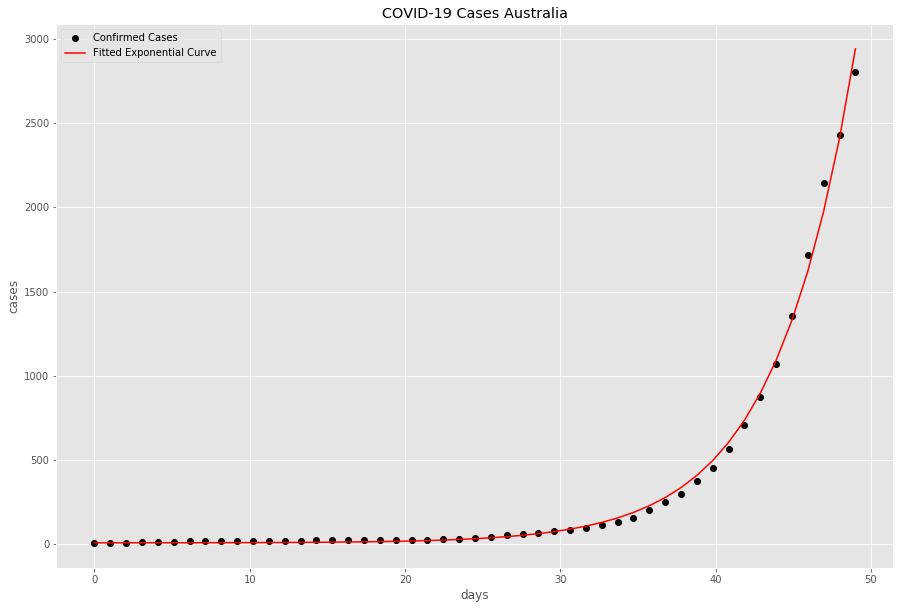

In [16]:
from scipy.optimize import curve_fit

def func(x, a, b, c):
    return a * np.exp(b * x) + c


x = np.linspace(0, df.shape[0], df.shape[0])
confirmed = df.confirmed.values
popt, pcov = curve_fit(func, x, confirmed, bounds=(0, [20., 1., 10.]))

print('a: {0} b: {1} c: {2}'.format(popt[0], popt[1], popt[2]))

fig = plt.figure(figsize=(15, 10))
plt.plot(x, confirmed, 'ko', label="Confirmed Cases")
plt.plot(x, func(x, *popt), 'r-', label="Fitted Exponential Curve")
plt.title('COVID-19 Cases Australia')
plt.xlabel('days');
plt.ylabel('cases');
plt.legend();

# Future predictions

In [17]:
current_days = df.shape[0]
# find scale factor to match exactly 
# current days to max confirmed cases
scale_factor = 0
for i in range(0, 1000):
    scale_factor = scale_factor + 0.001
    result = func(current_days - scale_factor, *popt)
    if (result - df.confirmed.max()) < 0:
        break

day = 1 - scale_factor
print(day)
print('Current total: {0:,}'.format(df.confirmed.max()))
print('Predicted next day: {0:,}'.format(int(func(current_days + day, *popt))))
print('Predicted next three days: {0:,}'.format(int(func(current_days + 3 * day, *popt))))
print('Predicted next week (7 days): {0:,}'.format(int(func(current_days + 7 * day, *popt))))
print('Predicted in two weeks (14 days): {0:,}'.format(int(func(current_days + 14 * day, *popt))))

0.7519999999999998
Current total: 2,805
Predicted next day: 3,407
Predicted next three days: 4,567
Predicted next week (7 days): 8,207
Predicted in two weeks (14 days): 22,906
